In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import copy

In [4]:
# Load the dataset
import kagglehub
path = kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance")
df = pd.read_csv(path + '/student_habits_performance.csv')

# Separate features and target
df = df.drop(columns=['student_id'])
X = df.drop(columns=['exam_score'])
y = df['exam_score'].values

# Identify column types
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   gender                         1000 non-null   object 
 2   study_hours_per_day            1000 non-null   float64
 3   social_media_hours             1000 non-null   float64
 4   netflix_hours                  1000 non-null   float64
 5   part_time_job                  1000 non-null   object 
 6   attendance_percentage          1000 non-null   float64
 7   sleep_hours                    1000 non-null   float64
 8   diet_quality                   1000 non-null   object 
 9   exercise_frequency             1000 non-null   int64  
 10  parental_education_level       909 non-null    object 
 11  internet_quality               1000 non-null   object 
 12  mental_health_rating           1000 non-null   in

In [5]:
# Build preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# Apply preprocessing
X_train_val_processed = preprocessor.fit_transform(X_train_val)
X_test_processed = preprocessor.transform(X_test)

# Save preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

# Convert to tensors
X_train_val_tensor = torch.tensor(X_train_val_processed, dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

print("Processed X_train_val shape:", X_train_val_tensor.shape)
print("Processed X_test shape:", X_test_tensor.shape)
for col in ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']:
    print(f"{col} unique values:", df[col].unique())

Processed X_train_val shape: torch.Size([800, 25])
Processed X_test shape: torch.Size([200, 25])
gender unique values: ['Female' 'Male' 'Other']
part_time_job unique values: ['No' 'Yes']
diet_quality unique values: ['Fair' 'Good' 'Poor']
parental_education_level unique values: ['Master' 'High School' 'Bachelor' nan]
internet_quality unique values: ['Average' 'Poor' 'Good']
extracurricular_participation unique values: ['Yes' 'No']


In [6]:
# Define models
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class DeepNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class DeeperNet(nn.Module):
    def __init__(self, input_dim):
        super(DeeperNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
def train_model(model_class, X_tensor, y_tensor, learning_rate, batch_size, epochs=150, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mses, rmses, maes, mapes, r2s = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

        model = model_class(X_tensor.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_preds_np = val_preds.numpy().flatten()
            y_val_np = y_val.numpy().flatten()

            # Compute metrics
            mse = mean_squared_error(y_val_np, val_preds_np)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_val_np, val_preds_np)
            mape = mean_absolute_percentage_error(y_val_np, val_preds_np) * 100
            r2 = r2_score(y_val_np, val_preds_np)

            mses.append(mse)
            rmses.append(rmse)
            maes.append(mae)
            mapes.append(mape)
            r2s.append(r2)

    return np.mean(mses), np.mean(rmses), np.mean(maes), np.mean(mapes), np.mean(r2), model

In [8]:
# Test the best model on the test set
def test_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        test_preds_np = test_preds.numpy().flatten()
        y_test_np = y_test_tensor.numpy().flatten()

        test_mse = mean_squared_error(y_test_np, test_preds_np)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test_np, test_preds_np)
        test_mape = mean_absolute_percentage_error(y_test_np, test_preds_np) * 100
        test_r2 = r2_score(y_test_np, test_preds_np)

    return test_mse, test_rmse, test_mae, test_mape, test_r2

In [10]:
# Hyperparameter tuning
learning_rates = [0.0001, 0.00005, 0.00001]
batch_sizes = [16, 32, 64]
architectures = [SimpleNet, DeepNet, DeeperNet]
k_folds_list = [3, 5]

best_results = {
    "mse": (float("inf"), None, None),
    "rmse": (float("inf"), None, None),
    "mae": (float("inf"), None, None),
    "mape": (float("inf"), None, None),
    "r2": (-float("inf"), None, None),
}

for k_folds in k_folds_list:
    for lr in learning_rates:
        for bs in batch_sizes:
            for arch in architectures:
                print(f"Evaluating {arch.__name__} with lr={lr}, batch_size={bs}, k_folds={k_folds}")
                avg_mse, avg_rmse, avg_mae, avg_mape, avg_r2, trained_model = train_model(
                    arch, X_train_val_tensor, y_train_val_tensor, lr, bs, epochs=150, k_folds=k_folds
                )
                test_mse, test_rmse, test_mae, test_mape, test_r2 = test_model(trained_model, X_test_tensor, y_test_tensor)

                print(f"Validation | MSE: {avg_mse:.4f}, RMSE: {avg_rmse:.4f}, MAE: {avg_mae:.4f}, MAPE: {avg_mape:.2f}%, R2: {avg_r2:.4f}")
                print(f"Test | MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%, R2: {test_r2:.4f}\n")

                # Update bests
                metrics = {
                    "mse": avg_mse,
                    "rmse": avg_rmse,
                    "mae": avg_mae,
                    "mape": avg_mape,
                    "r2": avg_r2
                }
                test_results = (test_mse, test_rmse, test_mae, test_mape, test_r2)
                params = {'model': arch.__name__, 'lr': lr, 'batch_size': bs, 'k_folds': k_folds}

                for metric in best_results:
                    if (metric != "r2" and metrics[metric] < best_results[metric][0]) or (metric == "r2" and metrics[metric] > best_results[metric][0]):
                        best_results[metric] = (metrics[metric], params, test_results)

# Print best configurations and test results
for metric in best_results:
    val_score, params, test_scores = best_results[metric]
    print(f"\nBest configuration for Validation {metric.upper()}: {params}")
    print(f"Validation {metric.upper()}: {val_score:.4f}")
    print(f"Test MSE: {test_scores[0]:.4f}, RMSE: {test_scores[1]:.4f}, MAE: {test_scores[2]:.4f}, MAPE: {test_scores[3]:.2f}%, R2: {test_scores[4]:.4f}")

Evaluating SimpleNet with lr=0.0001, batch_size=16, k_folds=3
Validation | MSE: 35.6132, RMSE: 5.9642, MAE: 4.7270, MAPE: 7.29%, R2: 0.8627
Test | MSE: 28.9629, RMSE: 5.3817, MAE: 4.4081, MAPE: 7.21%, R2: 0.8871

Evaluating DeepNet with lr=0.0001, batch_size=16, k_folds=3
Validation | MSE: 50.1359, RMSE: 7.0584, MAE: 5.6106, MAPE: 8.87%, R2: 0.7866
Test | MSE: 46.5065, RMSE: 6.8196, MAE: 5.5357, MAPE: 8.87%, R2: 0.8186

Evaluating DeeperNet with lr=0.0001, batch_size=16, k_folds=3
Validation | MSE: 51.6814, RMSE: 7.1866, MAE: 5.7326, MAPE: 8.86%, R2: 0.8112
Test | MSE: 50.4902, RMSE: 7.1056, MAE: 5.7336, MAPE: 8.90%, R2: 0.8031

Evaluating SimpleNet with lr=0.0001, batch_size=32, k_folds=3
Validation | MSE: 32.0100, RMSE: 5.6549, MAE: 4.4323, MAPE: 6.86%, R2: 0.8774
Test | MSE: 27.7868, RMSE: 5.2713, MAE: 4.3357, MAPE: 7.11%, R2: 0.8916

Evaluating DeepNet with lr=0.0001, batch_size=32, k_folds=3
Validation | MSE: 40.9921, RMSE: 6.3927, MAE: 5.0853, MAPE: 7.93%, R2: 0.8331
Test | MSE: 

In [11]:
# Higher learning rates don't work with Deeper networks
learning_rates = [0.002, 0.001, 0.0005]
batch_sizes = [16, 32, 64]
architectures = [SimpleNet]
k_folds_list = [3, 5]

best_results = {
    "mse": (float("inf"), None, None),
    "rmse": (float("inf"), None, None),
    "mae": (float("inf"), None, None),
    "mape": (float("inf"), None, None),
    "r2": (-float("inf"), None, None),
}

for k_folds in k_folds_list:
    for lr in learning_rates:
        for bs in batch_sizes:
            for arch in architectures:
                print(f"Evaluating {arch.__name__} with lr={lr}, batch_size={bs}, k_folds={k_folds}")
                avg_mse, avg_rmse, avg_mae, avg_mape, avg_r2, trained_model = train_model(
                    arch, X_train_val_tensor, y_train_val_tensor, lr, bs, epochs=150, k_folds=k_folds
                )
                test_mse, test_rmse, test_mae, test_mape, test_r2 = test_model(trained_model, X_test_tensor, y_test_tensor)

                print(f"Validation | MSE: {avg_mse:.4f}, RMSE: {avg_rmse:.4f}, MAE: {avg_mae:.4f}, MAPE: {avg_mape:.2f}%, R2: {avg_r2:.4f}")
                print(f"Test | MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%, R2: {test_r2:.4f}\n")

                # Update bests
                metrics = {
                    "mse": avg_mse,
                    "rmse": avg_rmse,
                    "mae": avg_mae,
                    "mape": avg_mape,
                    "r2": avg_r2
                }
                test_results = (test_mse, test_rmse, test_mae, test_mape, test_r2)
                params = {'model': arch.__name__, 'lr': lr, 'batch_size': bs, 'k_folds': k_folds}

                for metric in best_results:
                    if (metric != "r2" and metrics[metric] < best_results[metric][0]) or (metric == "r2" and metrics[metric] > best_results[metric][0]):
                        best_results[metric] = (metrics[metric], params, test_results)

# Print best configurations and test results
for metric in best_results:
    val_score, params, test_scores = best_results[metric]
    print(f"\nBest configuration for Validation {metric.upper()}: {params}")
    print(f"Validation {metric.upper()}: {val_score:.4f}")
    print(f"Test MSE: {test_scores[0]:.4f}, RMSE: {test_scores[1]:.4f}, MAE: {test_scores[2]:.4f}, MAPE: {test_scores[3]:.2f}%, R2: {test_scores[4]:.4f}")

Evaluating SimpleNet with lr=0.002, batch_size=16, k_folds=3
Validation | MSE: 61.8342, RMSE: 7.8215, MAE: 6.1737, MAPE: 9.52%, R2: 0.7926
Test | MSE: 58.5387, RMSE: 7.6511, MAE: 6.1539, MAPE: 9.78%, R2: 0.7717

Evaluating SimpleNet with lr=0.002, batch_size=32, k_folds=3
Validation | MSE: 58.1222, RMSE: 7.6050, MAE: 6.1203, MAPE: 9.50%, R2: 0.8005
Test | MSE: 42.2003, RMSE: 6.4962, MAE: 5.2904, MAPE: 8.33%, R2: 0.8354

Evaluating SimpleNet with lr=0.002, batch_size=64, k_folds=3
Validation | MSE: 46.4458, RMSE: 6.8119, MAE: 5.4424, MAPE: 8.39%, R2: 0.8415
Test | MSE: 41.8781, RMSE: 6.4713, MAE: 5.2551, MAPE: 8.10%, R2: 0.8367

Evaluating SimpleNet with lr=0.001, batch_size=16, k_folds=3
Validation | MSE: 57.6681, RMSE: 7.5917, MAE: 6.0308, MAPE: 9.33%, R2: 0.7844
Test | MSE: 43.1727, RMSE: 6.5706, MAE: 5.3345, MAPE: 8.58%, R2: 0.8316

Evaluating SimpleNet with lr=0.001, batch_size=32, k_folds=3
Validation | MSE: 47.7594, RMSE: 6.9062, MAE: 5.5043, MAPE: 8.56%, R2: 0.8158
Test | MSE: 3

In [9]:
# Retrain best model using best hyperparameters
print(f"Retraining with: lr={5e-05}, batch_size={32}, k_folds={5}")

# Retrain model
_, _, _, _, _, simplenet_model = train_model(
    SimpleNet,
    X_train_val_tensor,
    y_train_val_tensor,
    5e-05,
    32,
    k_folds=5
)

# Save the trained model
torch.save(simplenet_model.state_dict(), 'simplenet_model.pth')

Retraining with: lr=5e-05, batch_size=32, k_folds=5


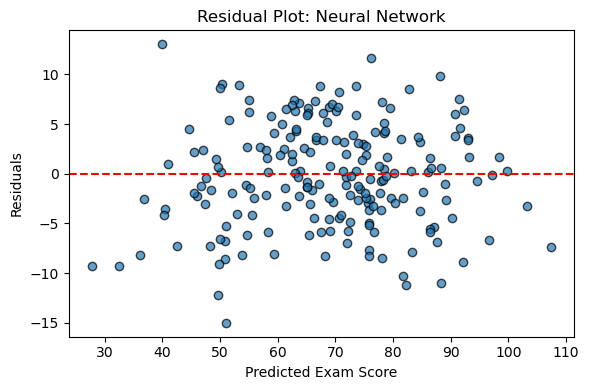

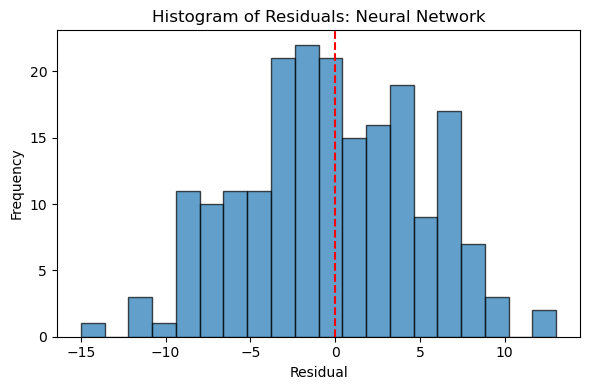

In [10]:
# Residuals plotting
simplenet_model.eval()
with torch.no_grad():
    y_pred_tensor = simplenet_model(X_test_tensor)
y_pred = y_pred_tensor.numpy().flatten()

residuals_nn = y_test - y_pred

# Residual scatter plot
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals_nn, alpha=0.7, edgecolor='k')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Exam Score")
plt.ylabel("Residuals")
plt.title("Residual Plot: Neural Network")
plt.tight_layout()
plt.show()

# Residual histogram
plt.figure(figsize=(6,4))
plt.hist(residuals_nn, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(0, linestyle='--', color='red')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals: Neural Network")
plt.tight_layout()
plt.show()

In [12]:
# Take the best model and drop each features once to see the results
# List of original features (before one-hot encoding)
original_features = X.columns.tolist()
feature_impacts = []

for feature_to_drop in original_features:
    print(f"\nDropping feature: {feature_to_drop}")

    # Drop from original DataFrame
    X_dropped = X.drop(columns=[feature_to_drop])
    
    # Identify new column types
    cat_cols_dropped = X_dropped.select_dtypes(include='object').columns.tolist()
    num_cols_dropped = X_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Split again
    X_train_val_dropped, _, y_train_val_dropped, _ = train_test_split(X_dropped, y, test_size=0.2, random_state=42)
    
    # Refit preprocessor for the reduced feature set
    preprocessor_dropped = ColumnTransformer([
        ('num', StandardScaler(), num_cols_dropped),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols_dropped)
    ])
    
    # Transform
    X_train_val_processed_dropped = preprocessor_dropped.fit_transform(X_train_val_dropped)
    
    # Convert to tensor
    X_train_val_tensor_dropped = torch.tensor(X_train_val_processed_dropped, dtype=torch.float32)
    y_train_val_tensor_dropped = torch.tensor(y_train_val_dropped.reshape(-1, 1), dtype=torch.float32)

    # Retrain model and evaluate
    mse, rmse, mae, mape, r2, _ = train_model(
        SimpleNet,
        X_train_val_tensor_dropped,
        y_train_val_tensor_dropped,
        learning_rate=5e-05,
        batch_size=32,
        k_folds=5
    )
    
    feature_impacts.append({
        'feature_dropped': feature_to_drop,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    })

# Convert to DataFrame and sort by MSE
feature_importance_df = pd.DataFrame(feature_impacts)
feature_importance_df_sorted = feature_importance_df.sort_values(by='mse', ascending=False)

print("\nFeature Importance by feature dropped")
print(feature_importance_df_sorted)


Dropping feature: age

Dropping feature: gender

Dropping feature: study_hours_per_day

Dropping feature: social_media_hours

Dropping feature: netflix_hours

Dropping feature: part_time_job

Dropping feature: attendance_percentage

Dropping feature: sleep_hours

Dropping feature: diet_quality

Dropping feature: exercise_frequency

Dropping feature: parental_education_level

Dropping feature: internet_quality

Dropping feature: mental_health_rating

Dropping feature: extracurricular_participation

Feature Importance by feature dropped
                  feature_dropped         mse       rmse        mae  \
2             study_hours_per_day  241.452011  15.515769  12.423943   
12           mental_health_rating   61.652325   7.832694   6.375991   
3              social_media_hours   40.723780   6.365564   4.995633   
9              exercise_frequency   38.247268   6.168934   4.892186   
4                   netflix_hours   36.903389   6.059781   4.788553   
7                     sleep_hour